# Safe4All Workshop

The primary objective is to equip national meteorological agencies with the skills to access, explore, and apply the high-resolution reanalysis dataset. A specific focus will be on understanding severe weather events, such as extreme rainfall, high winds, and temperature anomalies, and comparing this with the annual yield by FAOSTAT.<br><br>

###  Objectives
1. Understanding and Accessing the data in Ghana, Kenya and ZImbabwe (CBAM, ERA5, CHIRPS, TAMSAT, TAHMO and NOAA ground stations)
2. Applying the data to Severe weather forecasting
3. Looking at the yield for the different regions
<br>
<br>

## Understanding the data
1. TAHMO (Trans-African Hydro-Meteorological Observatory)
  - Provides high-resolution weather and climate data collected from a network of ground stations across Africa. <br>
  [TAHMO Website](https://tahmo.org/)

2. CBAM
  - Offers data and analytical tools for monitoring and assessing climate and environmental conditions.

3. Global Historical Climatology Network daily (GHCNd)
  - The Global Historical Climatology Network daily (GHCNd) is an integrated database of daily climate summaries from land surface stations across the globe
  - GHCNd contains records from more than 100,000 stations in 180 countries and territories.<br>
  [NCEI Ground Stations](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily)

4. ECMWF Reanalysis v5 (ERA5)
  - Provides a comprehensive, global reanalysis of historical weather and climate data from the European Centre for Medium-Range Weather Forecasts.<br>
  [ERA5 Website](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5)

5. CHIRPS (Climate Hazards Group InfraRed Precipitation with Station Data)
  - CHIRPS incorporates 0.05° resolution satellite imagery with insitu station data to create gridded rainfall time series for trend analysis and seasonal drought monitoring. <BR>
  [CHIRPS Website](https://www.icpac.net/data-center/chirps/)

6. TAMSAT (Tropical Applications of Meteorology using SATellite data)
  - Enhances the capacity of African meteorological agencies and other organisations by providing and supporting the use of satellite-based rainfall estimates, soil moisture estimates and forecasts, and related data products.<br>
  [TAMSAT Website](https://research.reading.ac.uk/tamsat/)

7. FAOSTAT (Food and Agriculture Organization Statistics)
  - FAOSTAT provides free access to food and agriculture statistics (including crop, livestock, and forestry sub-sectors) for over 245 countries and territories and covers all FAO regional groupings from 1961 to the most recent year available.<br>
  [FAOSTAT Website](https://www.fao.org/faostat/en/#home)
<br><br>

### Requirements
- API access to TAHMO
- API Access to CBAM
- Token Access from NCEI
- Google Account

## Dependencies

In [ ]:
%pip install -r requirements.txt

In [ ]:
!jupyter nbextension enable --py widgetsnbextension


In [ ]:
import ee
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors
import math
import datetime
import io
from tqdm import tqdm
from datetime import datetime, timedelta
from IPython.display import HTML, display
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from filter_stations import retreive_data, Filter
import base64
import json
import requests
import os

curr_dir = os.getcwd()


In [ ]:
config_path = 'config.json'

with open(config_path) as f:
    config = json.load(f)

# authenticate the api
api_key = config['apiKey']
api_secret = config['apiSecret']
maps_key = config['map_api_key']

ret = retreive_data(api_key, api_secret, maps_key)
fs = Filter(api_key, api_secret, maps_key)

In [ ]:
import sys
sys.path.append('utils')

In [ ]:
# Load the different helper functions
from utils.helpers import df_to_xarray, get_region_geojson, bbox_from_polygon # General helper functions
from utils.CBAM_helpers import CBAMClient, extract_cbam_data # CBAM helper functions
from utils.ERA5_helpers import era5_var_handling, era5_data_extracts # ERA5 helper functions
from utils.CHIRPS_helpers import extract_chirps_daily # CHIRPS helper functions
from utils.plotting import select, scale, plot_xarray_data, plot_xarray_data2, compare_xarray_datasets, compare_xarray_datasets2 # Plotting helper functions
from utils.GHCN_stations import subset_stations_in_bbox # GHCN station helper functions
from utils.faostat_helpers import fetch_yield_data, get_crop_code, get_country_code # FAOSTAT helper functions
from utils.ground_stations import plot_stations_folium

### Create Config file
```json
{
    "apiKey": "", # TAHMO api key 
    "apiSecret": "", # TAHMO API Secret
    "map_api_key": "", # Google Maps API Key
    "cbam_api_key": "",
    "noaa_stations_token": "",
    "username": "", # CBAM GAP Username
    "password": "" # CBAM GAP Password
}

### Region of Interest Coordinates

### Accra Centre Point

In [ ]:
# Get Accra Coordinates
accra_lat, accra_lon = fs.centre_point('Accra')
# Get 100 km within Accra region
accra_bbox = fs.compute_filter(accra_lat, accra_lon, 100)

### Ghana Region

In [ ]:
region_name = "East Africa"
geojson = get_region_geojson(region_name, maps_key)
print(json.dumps(geojson, indent=2))

## Extracting CBAM data
1. Request API access to extract the data set
2. Get the coordinates of the Kigali region
3. Extract the data
4. Visualise the image of the data in Kigali region from 2012 for total precipitation and minimum and maximum


In [ ]:
# Define parameters as shown in the docs
product = 'cbam_historical_analysis'
attribs = ["max_temperature", "min_temperature", "total_rainfall"]
start_date = '2023-01-01'
end_date = '2023-01-31'
bbox = bbox_from_polygon("Kenya", maps_key=maps_key)
print(bbox)

# Create a client and extract data
client = CBAMClient('config.json')
cbam_data = extract_cbam_data(start_date=start_date, end_date=end_date, 
                         attributes=attribs, cbam_client=client, bbox=bbox,
                         output_type='csv')


In [ ]:
cbam_data

In [ ]:
plot_xarray_data2(
    xarray_ds=cbam_data,
    fig_title="Multi-variable Analysis CBAM Kenya",
    columns=["max_temperature", "min_temperature", "total_rainfall"],
    plot_size=6,
    region_name="Kenya",
    maps_key=maps_key,
    save=True
)

In [ ]:
# Define parameters as shown in the docs
product = 'cbam_historical_analysis'
attribs = ["max_temperature", "min_temperature", "total_rainfall"]
start_date = '2023-01-01'
end_date = '2023-01-07'
bbox = bbox_from_polygon("Africa", maps_key=maps_key)
print(bbox)

# Create a client and extract data
client = CBAMClient('config.json')
cbam_data = extract_cbam_data(start_date=start_date, end_date=end_date, 
                         attributes=attribs, cbam_client=client, bbox=bbox,
                         output_type='csv')


In [ ]:
# sort the latitudes
cbam_data = cbam_data.sortby('lat')
# sort the longitudes
cbam_data = cbam_data.sortby('lon')

In [ ]:
cbam_data['max_temperature'].isel(time=0).plot(
    x="lon", y="lat", 
    cmap="viridis", 
    robust=True,
    subplot_kws={"projection": ccrs.PlateCarree()},
    transform=ccrs.PlateCarree()
)


In [ ]:
# Plot the data
plot_xarray_data2(
    xarray_ds=cbam_data,
    fig_title="Multi-variable Analysis CBAM Africa",
    columns=["max_temperature", "min_temperature", "total_rainfall"],
    plot_size=6,
    region_name="Africa",
    maps_key=maps_key
)

## Extracting ERA5 data

1. Set up Google Earth Engine Project to access and extract the data
2. Visualise the image of the data in Kigali and Nairobi region from 1970 for temperature, rainfall and windspeed

### Steps to setting up Google Earth Engine Project

1. Get started from the link https://code.earthengine.google.com/register
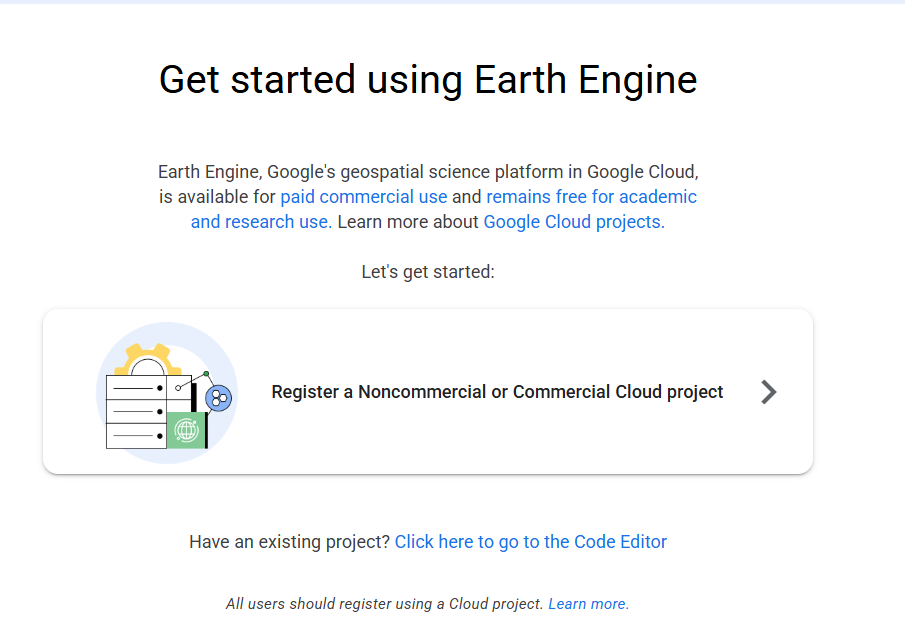

2. 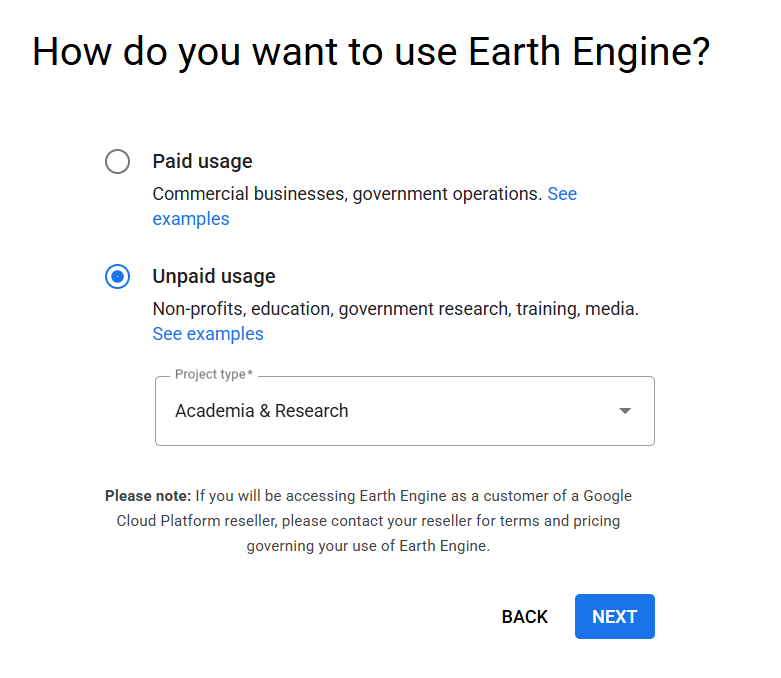

3. 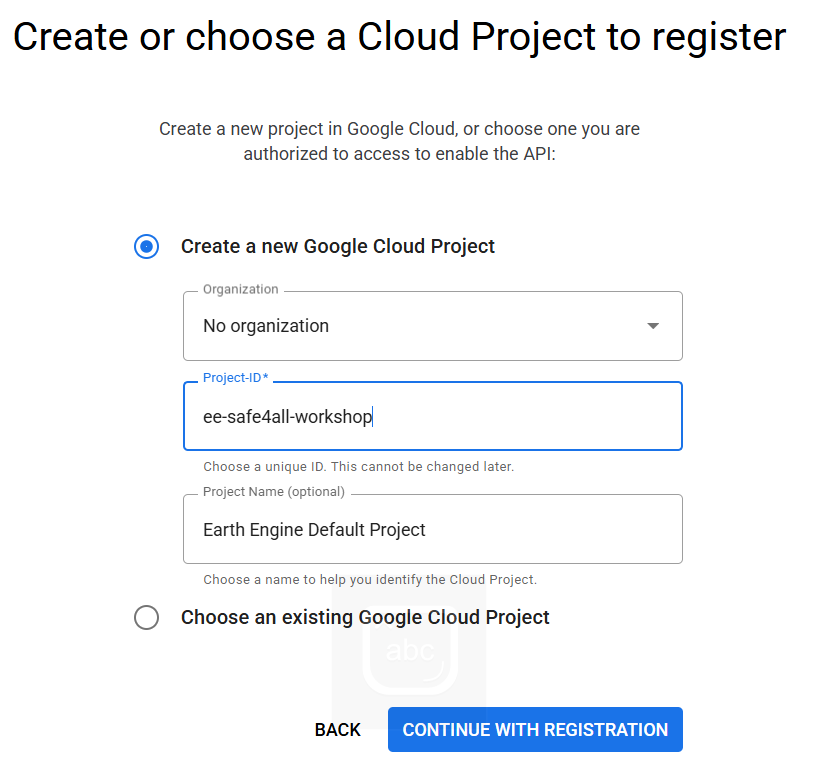

4. 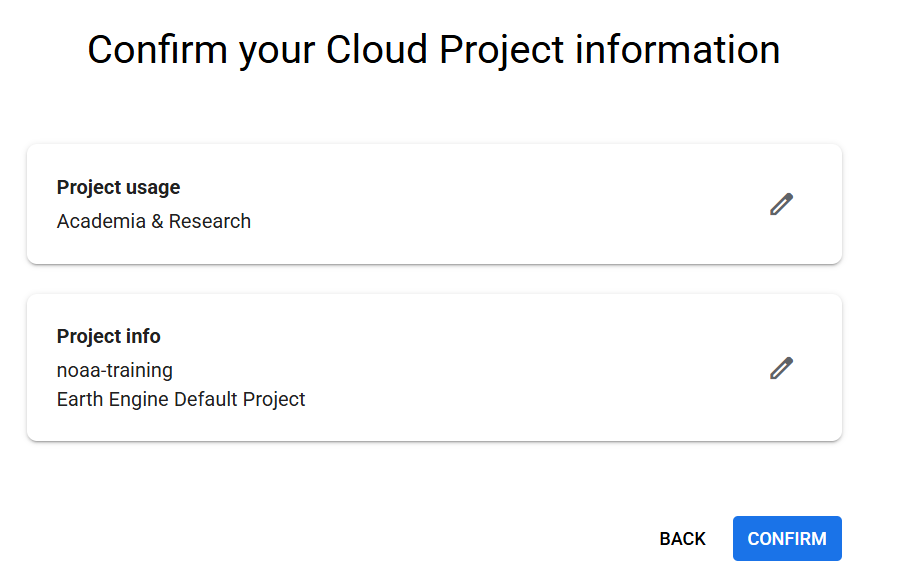

In [ ]:
# Authenticate Earth Engine API
ee.Authenticate()

In [ ]:
# Initialize Google Earth Engine
ee.Initialize(project='ee-safe4all-workshop')

### Ghana

In [ ]:
start_date = '2023-01-01T00:00:00'
end_date   = '2023-01-31T00:00:00'
region_name = 'Ghana'
era5_gh_data = era5_data_extracts(region_name, start_date, end_date, maps_key, era5_l=False)

In [ ]:
te_ds_era5_gh = era5_var_handling(era5_gh_data, 'temperature_2m', xarray_ds=True)
pr_ds_era5_gh = era5_var_handling(era5_gh_data, 'total_precipitation', xarray_ds=True)
# ws_ds_era5_gh = era5_var_handling(era5_gh_data, 'wind_speed', xarray_ds=True)
merged_era5_gh = xr.merge([te_ds_era5_gh, pr_ds_era5_gh])
merged_era5_gh

In [ ]:

plot_xarray_data2(
    xarray_ds=merged_era5_gh,
    fig_title="ERA5 Temperature and Precipitation Analysis Ghana",
    columns=["temperature_2m", "total_precipitation"],
    plot_size=6,
    region_name="Ghana",
    maps_key=maps_key,
    save=False
)

In [ ]:
substring = 'wind'

# List comprehension to find keys containing the substring
matching_keys = [key for key in era5_gh_data if substring in key]

print(matching_keys)

In [ ]:
# Plot Temperature data
plot_xarray_data(te_ds_era5_gh, 'Temperature in Ghana in degrees Celsius',
                 column='temperature_2m', plot_size=7, robust=True, region='Ghana')

In [ ]:
# Plot Rainfall data
plot_xarray_data(pr_ds_era5_gh, 'Rainfall in Ghana in mm',
                 column='total_precipitation', plot_size=7, robust=True, region='Ghana')


### Zimbabwe

In [ ]:
start_date = '2023-01-01T00:00:00'
end_date   = '2023-01-31T00:00:00'
region_name = 'Zimbabwe'
era5_zw_data = era5_data_extracts(region_name, start_date, end_date, maps_key, era5_l=False)

In [ ]:
te_ds_era5_zw = era5_var_handling(era5_zw_data, 'temperature_2m', xarray_ds=True)
pr_ds_era5_zw = era5_var_handling(era5_zw_data, 'total_precipitation', xarray_ds=True)
# ws_ds_era5_gh = era5_var_handling(era5_zw_data, 'wind_speed', xarray_ds=True)
merged_era5_zw = xr.merge([te_ds_era5_zw, pr_ds_era5_zw])
# sort the latitudes
merged_era5_zw = merged_era5_zw.sortby('lat')
# sort the longitudes
merged_era5_zw = merged_era5_zw.sortby('lon')
merged_era5_zw

In [ ]:
plot_xarray_data2(
    xarray_ds=merged_era5_zw,
    fig_title="ERA5 Temperature and Precipitation Analysis in Zimbabwe",
    columns=["temperature_2m", "total_precipitation"],
    plot_size=6,
    region_name="Zimbabwe",
    maps_key=maps_key
)

In [ ]:
# Plot Temperature data
plot_xarray_data(te_ds_era5_zw, 'Temperature in Zimbabwe in degrees Celsius',
                 column='temperature_2m', plot_size=7, robust=True, region=region_name)

In [ ]:
# Plot Rainfall data
plot_xarray_data(pr_ds_era5_gh, 'Rainfall in Zimbabwe in mm',
                 column='total_precipitation', plot_size=7, robust=True, region=region_name)


### Kenya

In [ ]:
start_date = '2023-01-01T00:00:00'
end_date   = '2023-01-31T00:00:00'
region_name = 'Kenya'
era5_ke_data = era5_data_extracts(region_name, start_date, end_date, maps_key, era5_l=False)

In [ ]:
te_ds_era5_ke = era5_var_handling(era5_ke_data, 'temperature_2m', xarray_ds=True)
pr_ds_era5_ke = era5_var_handling(era5_ke_data, 'total_precipitation', xarray_ds=True)
# ws_ds_era5_gh = era5_var_handling(era5_gh_data, 'wind_speed', xarray_ds=True)
merged_era5_ke = xr.merge([te_ds_era5_ke, pr_ds_era5_ke])
# sort the latitudes
merged_era5_ke = merged_era5_ke.sortby('lat')
# sort the longitudes
merged_era5_ke = merged_era5_ke.sortby('lon')

In [ ]:
plot_xarray_data2(
    xarray_ds=merged_era5_ke,
    fig_title="ERA5 Temperature and Precipitation Analysis in Kenya",
    columns=["temperature_2m", "total_precipitation"],
    plot_size=6,
    region_name="Kenya",
    maps_key=maps_key
)

In [ ]:
# Plot Temperature data
plot_xarray_data(te_ds_era5_ke, 'Temperature in Kenya in degrees Celsius',
                 column='temperature_2m', plot_size=7, robust=True, region='Kenya')

In [ ]:
# Plot Rainfall data
plot_xarray_data(pr_ds_era5_ke, 'Rainfall in Kenya in mm',
                 column='total_precipitation', plot_size=7, robust=True, region='Kenya')


### Compare Kenya, Ghana and Zimbabwe

In [ ]:
# Compare precipitation data in Kenya, Zimbabwe and Ghana
compare_xarray_datasets([pr_ds_era5_ke, pr_ds_era5_zw, pr_ds_era5_gh], 
                        ['Kenya', 'Zimbabwe', 'Ghana'], 
                        'Total Precipitation in Kenya, Zimbabwe and Ghana in mm', 
                        bbox=bbox_from_polygon('Africa', maps_key=maps_key), cols=3,
                        plot_size=7, robust=True)

In [ ]:
# Compare precipitation data in Kenya, Zimbabwe and Ghana
compare_xarray_datasets2(
    [pr_ds_era5_ke, pr_ds_era5_zw, pr_ds_era5_gh], 
    ['Kenya', 'Zimbabwe', 'Ghana'], 
    'Total Precipitation in Kenya, Zimbabwe and Ghana in mm', 
    bbox=bbox_from_polygon('Africa', maps_key=maps_key),
    cols=3,
    plot_size=7, 
    robust=True,
    save=True
)

In [ ]:
# Comparing temperature data in Kenya, Zimbabwe and Ghana
compare_xarray_datasets([te_ds_era5_ke, te_ds_era5_zw, te_ds_era5_gh], 
                        ['Kenya', 'Zimbabwe', 'Ghana'], 
                        'Temperature in Kenya, Zimbabwe and Ghana in degrees Celsius', 
                        bbox=bbox_from_polygon('Africa', maps_key=maps_key), cols=3,
                        plot_size=7, robust=True)

### Africa

In [ ]:
start_date = '2025-01-01T00:00:00'
end_date   = '2025-01-31T00:00:00'
region_name = 'Africa'
era5_af_data = era5_data_extracts(region_name, start_date, end_date, maps_key, era5_l=False)

In [ ]:
te_ds_era5_af = era5_var_handling(era5_af_data, 'temperature_2m', xarray_ds=True)
pr_ds_era5_af = era5_var_handling(era5_af_data, 'total_precipitation', xarray_ds=True)
# ws_ds_era5_gh = era5_var_handling(era5_gh_data, 'wind_speed', xarray_ds=True)
merged_era5_af = xr.merge([te_ds_era5_af, pr_ds_era5_af])

In [ ]:
plot_xarray_data2(
    xarray_ds=merged_era5_af,
    fig_title="ERA5 Temperature and Precipitation Analysis in Africa",
    columns=["temperature_2m", "total_precipitation"],
    plot_size=6,
    region_name="Africa",
    maps_key=maps_key,
    save=True
)

In [ ]:
plot_xarray_data2(
    xarray_ds=merged_era5_af,
    fig_title="ERA5 Temperature and Precipitation Analysis in Africa",
    columns=["temperature_2m", "total_precipitation"],
    plot_size=6,
    region_name="Africa",
    maps_key=maps_key,
    save=True
)

In [ ]:
# Plot Temperature data
plot_xarray_data(te_ds_era5_af, 'Temperature in Africa in degrees Celsius',
                 column='temperature_2m', plot_size=7, robust=True, region='Africa')

In [ ]:
# Plot Rainfall data
plot_xarray_data(pr_ds_era5_af, 'Rainfall in Africa in mm',
                 column='total_precipitation', plot_size=7, robust=True, region='Africa')


## Extracting CHIRPS data

1. Extract the data from Google Earth engine project
2. Visualize the image of the data in Nairobi and Kampala from 1980 for rainfall data

In [ ]:
import ee
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors
import math
import datetime
import io
from tqdm import tqdm
from datetime import datetime, timedelta
from IPython.display import HTML, display
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from filter_stations import retreive_data, Filter
import base64
import json
import requests
from helpers import get_region_geojson
import datetime

def extract_chirps_daily(start_date_str, end_date_str, bbox=None, region_name=None, polygon=None, api_key=''):
    """
    Extract CHIRPS daily precipitation data from Google Earth Engine for a given bounding box and time range.
    The extraction is performed on a daily basis. For each day, the function:
      - Filters the CHIRPS daily image collection for that day.
      - Adds pixel coordinate bands (longitude and latitude).
      - Uses sampleRectangle to extract a grid of pixel values.
      - Organizes the results into a pandas DataFrame with the following columns:
          - date: The daily timestamp (ISO formatted)
          - latitude: The latitude coordinate of the pixel center
          - longitude: The longitude coordinate of the pixel center
          - precipitation: The pixel value representing daily precipitation.

    Args:
        start_date_str (str): Start datetime in ISO format, e.g., '2020-01-01T00:00:00'.
        end_date_str (str): End datetime in ISO format, e.g., '2020-01-02T00:00:00'.
        bbox (list or tuple): Bounding box specified as [minLon, minLat, maxLon, maxLat].

    Returns:
        pd.DataFrame: A pandas DataFrame containing the daily precipitation data.
    """
    # Convert input datetime strings to Python datetime objects.
    start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%dT%H:%M:%S')
    end_date   = datetime.datetime.strptime(end_date_str, '%Y-%m-%dT%H:%M:%S')

    # Handle the input from bbox to polygon to region name
    if bbox is not None:
        region = ee.Geometry.Rectangle(bbox)
    elif region_name is not None:
        # get the region geojson
        region_geo = get_region_geojson(region_name, api_key)
        polygon = region_geo['features'][0]['geometry']['coordinates'][0]
        region = ee.Geometry.Polygon(polygon)
    elif polygon is not None:
        region = ee.Geometry.Polygon(polygon)
    # Define a scale in meters corresponding approximately to the CHIRPS resolution (~0.05°).
    scale_m = 5000  # You might adjust this value depending on your needs.

    # This list will accumulate extracted records.
    results = []

    # Loop over each day in the specified time range.
    current = start_date
    while current < end_date:
        next_day = current + datetime.timedelta(days=1)

        # Format the current time window in ISO format.
        t0_str = current.strftime('%Y-%m-%dT%H:%M:%S')
        t1_str = next_day.strftime('%Y-%m-%dT%H:%M:%S')

        print(f"Processing {t0_str} to {t1_str}")

        # Filter the CHIRPS daily image collection for the current day.
        # The CHIRPS daily collection is available as 'UCSB-CHG/CHIRPS/DAILY'.
        collection = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
                        .filterDate(ee.Date(t0_str), ee.Date(t1_str))
        image = collection.first()

        # If no image is found for this day, skip to the next day.
        if image is None:
            current = next_day
            continue

        # Add bands containing the pixel longitude and latitude.
        image = image.addBands(ee.Image.pixelLonLat())

        # Use sampleRectangle to extract a grid of pixel values over the region.
        # The 'precipitation' band is part of the CHIRPS dataset.
        region_data = image.sampleRectangle(region=region, defaultValue=0).getInfo()

        # The pixel values for each band are in the "properties" dictionary.
        props = region_data['properties']

        # Extract the coordinate arrays from the added pixelLonLat bands.
        lon_array = props['longitude']  # 2D array of longitudes
        lat_array = props['latitude']   # 2D array of latitudes

        # Determine the dimensions of the extracted grid.
        nrows = len(lon_array)
        ncols = len(lon_array[0]) if nrows > 0 else 0

        # Loop over each pixel in the grid.
        for i in range(nrows):
            for j in range(ncols):
                pixel_lon = lon_array[i][j]
                pixel_lat = lat_array[i][j]
                # Extract the precipitation value.
                precip_value = props['precipitation'][i][j]
                record = {
                    'date': t0_str,  # daily timestamp as a string
                    'lat': pixel_lat,
                    'lon': pixel_lon,
                    'total_rainfall': precip_value
                }
                results.append(record)

        # Advance to the next day.
        current = next_day

    # Convert the accumulated results into a pandas DataFrame.
    df = pd.DataFrame(results)
    return df



In [ ]:
# Define the bounding box as [minLon, minLat, maxLon, maxLat]
ke_bbox = bbox_from_polygon('Kenya', maps_key)

# Define the extraction period (hourly)..
start_date = '2023-01-01T00:00:00'
end_date   = '2023-01-31T00:00:00'

df_chirps = extract_chirps_daily(start_date, end_date, bbox=ke_bbox)
chirps_pr_xr = df_to_xarray(df_chirps)


In [ ]:
# Plot the CHIRPS data
plot_xarray_data(chirps_pr_xr, 'CHIRPS Rainfall in Kenya in mm',
                 column='total_rainfall', plot_size=7, robust=True, region_name='Kenya', 
                 maps_key=maps_key)

### Ghana

In [ ]:
plot_xarray_data2(
    xarray_ds=chirps_pr_xr,
    fig_title="CHIRPS Rainfall in Kenya in mm",
    columns=["total_rainfall"],
    plot_size=6,
    region_name="Kenya",
    maps_key=maps_key,
    save=True
)

In [ ]:
gh_bbox = bbox_from_polygon('Ghana', maps_key)

# Define the extraction period
start_date = '2023-01-01T00:00:00'
end_date   = '2023-01-31T00:00:00'

df_chirps = extract_chirps_daily(start_date, end_date, bbox=gh_bbox)
chirps_pr_xr = df_to_xarray(df_chirps)

In [ ]:
# Plot the CHIRPS data
plot_xarray_data(chirps_pr_xr, 'CHIRPS Rainfall in Ghana in mm',
                 column='total_rainfall', plot_size=7, robust=True, region_name='Ghana', maps_key=maps_key)

### Africa

In [ ]:
af_bbox = bbox_from_polygon('Africa', maps_key)

# Define start and end date
df_chirps = extract_chirps_daily(start_date, end_date, bbox=af_bbox)
chirps_pr_xr = df_to_xarray(df_chirps)


In [ ]:
plot_xarray_data(chirps_pr_xr, 'CHIRPS Rainfall in Africa in mm',
                 column='precipitation', plot_size=7, robust=True, region='Africa')

In [ ]:
# Plot CHIRPS data
plot_xarray_data(chirps_pr_xr, "Total Rainfall (mm) Kigali Region", column="total_rainfall", plot_size=7, robust=True, bbox=[kigali_bbox[1],kigali_bbox[0], kigali_bbox[3], kigali_bbox[2]])

## Extracting TAMSAT data

### Setting Up

In [ ]:
# !git clone https://github.com/TAMSAT/tamsat_download_extraction_api

Handling Depracated numpy float to np.float64
<BR><BR>
Uncomment to run once

In [ ]:
# file_path = "tamsat_download_extraction_api/tamsat_download_extract_api.py"

# # Read the file
# with open(file_path, "r") as file:
#     content = file.read()

# # Replace np.float with np.float64
# content = content.replace("np.float", "np.float64")

# # Write back the modified content
# with open(file_path, "w") as file:
#     file.write(content)

# print("Successfully replaced np.float with np.float64.")


In [ ]:
import sys
sys.path.append('tamsat_download_extraction_api')

from tamsat_download_extract_api import download, extract


### Downloading rainfall satellite data for Africa
<!-- <BR><BR> -->
Uncomment to run once

In [ ]:
import os
curr_dir = os.getcwd()

# Download data
download({
 "timestep": 'daily',
 "resolution": 0.0375,
 "start_date": '2023-01-01',
 "end_date": '2023-01-31',
 "version": 3.1,
 "localdata_dir": f"{os.path.join(curr_dir, 'tamsat_data')}"
 })

### Ghana

In [ ]:
gh_w, gh_s, gh_e, gh_n = bbox_from_polygon('Ghana', maps_key)

In [ ]:
extract({
    "extract_type": 'domain',
    "S": gh_s,    
    "N": gh_n,    
    "W": gh_w,     
    "E": gh_e,      
    "timestep": 'daily',
    "start_date": '2023-01-01',
    "end_date": '2023-01-31',
    "version": 3.1,
    "localdata_dir": f"{os.path.join(curr_dir, 'tamsat_data')}",
    "resolution": 0.0375
})

In [ ]:
# %pip install netCDF4
# Load the xarray data
gh_tamsat_xarray = xr.open_dataset(
	r'd:\previous-pc\Agent\TAHMO\Safe4All\tamsat_data\extracted_data\domain\TAMSATv3.1_daily_0.0375_11.1750308_4.6339001_-3.2607859_1.199972_2023-01-01_2023-01-31.nc',
	# engine='netcdf4'
)
# sort the latitudes
gh_tamsat_xarray = gh_tamsat_xarray.sortby('lat')
gh_tamsat_xarray

In [ ]:
# plot the xarray
plot_xarray_data(gh_tamsat_xarray, 'TAMSAT Rainfall in Ghana in mm',
                 column='rfe_filled', plot_size=7, robust=True, region_name='Ghana', maps_key=maps_key)

### Kenya

In [ ]:
# Kenya region
kenya_w, kenya_s, kenya_e, kenya_n = bbox_from_polygon('Kenya', maps_key)
# Get the N,S,E,W coordinates from the bounding box

In [ ]:
extract({
    "extract_type": 'domain',
    "S": kenya_s,    # Minimum longitude
    "N": kenya_n,    # Maximum longitude
    "W": kenya_w,     # Minimum latitude
    "E": kenya_e,      # Maximum latitude
    "timestep": 'daily',
    "start_date": '2023-01-01',
    "end_date": '2023-01-31',
    "version": 3.1,
    "localdata_dir": f"{os.path.join(curr_dir, 'tamsat_data')}",
    "resolution": 0.0375
})

In [ ]:
# Load the xarray data
ke_tamsat_xarray = xr.open_dataset(
    r'd:\previous-pc\Agent\TAHMO\Safe4All\tamsat_data/extracted_data/domain/TAMSATv3.1_daily_0.0375_5.033420899999999_-4.724299999999999_33.90982109999999_41.9068688_2023-01-01_2023-01-31.nc',
    # engine='netcdf4'
)

# Sort by latitude
ke_tamsat_xarray = ke_tamsat_xarray.sortby('lat')


ke_tamsat_xarray

In [ ]:
# plot the xarray
plot_xarray_data(ke_tamsat_xarray, 'TAMSAT Rainfall in Kenya in mm',
                 column='rfe', plot_size=7, robust=True, region_name='Kenya', maps_key=maps_key)

In [ ]:
plot_xarray_data2(
    xarray_ds=ke_tamsat_xarray,
    fig_title="TAMSAT Rainfall in Kenya in mm",
    columns=["rfe"],
    plot_size=6,
    region_name="Kenya",
    maps_key=maps_key,
    save=True
)

### Zimbabwe

In [ ]:
zw_w, zw_s, zw_e, zw_n = bbox_from_polygon('Zimbabwe', maps_key)

extract({
    "extract_type": 'domain',
    "S": zw_s,    # Minimum longitude
    "N": zw_n,    # Maximum longitude
    "W": zw_w,     # Minimum latitude
    "E": zw_e,      # Maximum latitude
    "timestep": 'daily',
    "start_date": '2023-01-01',
    "end_date": '2023-01-31',
    "version": 3.1,
    "localdata_dir": f"{os.path.join(curr_dir, 'tamsat_data')}",
    "resolution": 0.0375
})

In [ ]:
# Load the xarray data
zw_tamsat_xarray = xr.open_dataset(
    r'd:\previous-pc\Agent\TAHMO\Safe4All\tamsat_data/extracted_data/domain/TAMSATv3.1_daily_0.0375_22.0_-22.5_32.5_33.5_2023-01-01_2023-01-31.nc',
    # engine='netcdf4'
)

In [ ]:
# Plot the xarray data
plot_xarray_data(zw_tamsat_xarray, 'TAMSAT Rainfall in Zimbabwe in mm',
                 column='rfe', plot_size=7, robust=True, region_name='Zimbabwe', maps_key=maps_key)

### Africa

In [ ]:
af_w, af_s, af_e, af_n = bbox_from_polygon('Africa', maps_key)
print(af_w, af_s, af_e, af_n)

extract({
    "extract_type": 'domain',
    "S": -34.834,    # Southernmost point of Africa
    "N": 37.21,      # Northernmost point of Africa
    "W": -17.625,    # Westernmost point of Africa
    "E": 51.27,      # Easternmost point of Africa
    "timestep": 'daily',
    "start_date": '2023-01-01',
    "end_date": '2023-01-31',
    "version": 3.1,
    "localdata_dir": f"{os.path.join(curr_dir, 'tamsat_data')}",
    "resolution": 0.0375
})

In [ ]:
# Load the xarray data
af_tamsat_xarray = xr.open_dataset(r'tamsat_data\extracted_data\domain\TAMSATv3.1_daily_0.0375_38.025_-35.9625_-19.0125_51.975_2023-01-01_2023-01-31.nc')
af_tamsat_xarray

In [ ]:
af_tamsat_xarray = af_tamsat_xarray.sortby('lat')  # Ensure latitude is sorted in ascending order


In [ ]:
# sort by longitude
af_tamsat_xarray = af_tamsat_xarray.sortby('lon')  # Ensure longitude is sorted in ascending order

In [ ]:
plot_xarray_data2(
    xarray_ds=af_tamsat_xarray,
    fig_title="TAMSAT Rainfall in Africa in mm",
    columns=["rfe_filled", 'rfe'],
    plot_size=6,
    region_name="Africa",
    maps_key=maps_key
)

In [ ]:
# Compute the mean of each variable over lat and lon, then plot both on the same figure
ke_mean_filled = ke_tamsat_xarray['rfe_filled'].mean(dim=['lat','lon'])
ke_mean = ke_tamsat_xarray['rfe'].mean(dim=['lat','lon'])

fig, ax = plt.subplots(figsize=(10, 6))
ke_mean_filled.plot(ax=ax, color='blue', label='Kenya TAMSAT (rfe_filled)')
ke_mean.plot(ax=ax, color='red', label='Kenya TAMSAT (rfe)')
ax.set_title('Mean TAMSAT Rainfall in Kenya')
ax.legend()
plt.show()

In [ ]:
datasets_list = [ds[['rfe']] for ds in [ke_tamsat_xarray, gh_tamsat_xarray, af_tamsat_xarray]]
labels_list = ["Kenya", "Ghana", "Africa"]
html_animation = compare_xarray_datasets(datasets_list, labels_list, "Comparison of TAMSAT Rainfall Data", 
                                          plot_size=9, robust=True, cols=3, bbox=bbox_from_polygon('Africa', maps_key))
display(html_animation)


## A Comparison of the Datasets
CBAM vs ERA5 vs
TAMSAT vs CHIRPS for both temperature and precipitation

In [ ]:
datasets_list = [ds[['rfe']] for ds in [ke_tamsat_xarray]]
datasets_list[0]

In [ ]:
cbam_pr = [ds[['total_rainfall']] for ds in [cbam_data]]
cbam_pr[0]

In [ ]:
# era5 ke -- pr_ds_era5_ke
# cbam ke -- cbam_data
# Subset precipitation cbam data as an xarray


compare_xarray_datasets(
    [cbam_pr[0], pr_ds_era5_ke, datasets_list[0]],
    ["CBAM", "ERA5", "TAMSAT"],
    "Comparison of Precipitation Data in Kenya",
    plot_size=7,
    robust=True,
    bboxes=[bbox_from_polygon('Kenya', maps_key),
            bbox_from_polygon('Kenya', maps_key),
            bbox_from_polygon('Kenya', maps_key)],
    cols=2,
    save=True
)

In [ ]:
# A comparison of the precipitation data in Kenya for the ERA5 and TAMSAT dataset
compare_xarray_datasets([pr_ds_era5_ke.sortby('lat'), datasets_list[0].sortby('lat')], 
                        ['ERA5', 'TAMSAT'], 
                        'Total Precipitation in Kenya in mm', 
                        bbox=bbox_from_polygon('Kenya', maps_key), cols=2,
                        plot_size=7, robust=True)

In [ ]:
# Precipitation data in Ghana for the ERA5 and TAMSAT dataset
compare_xarray_datasets([pr_ds_era5_gh, datasets_list[1]], 
                        ['ERA5', 'TAMSAT'], 
                        'Total Precipitation in Ghana in mm', 
                        bbox=bbox_from_polygon('Ghana', maps_key), cols=2,
                        plot_size=7, robust=True)

In [ ]:
# precipitation comparison in Zimbabwe for the ERA5 and TAMSAT dataset
compare_xarray_datasets([pr_ds_era5_zw, datasets_list[2]], 
                        ['ERA5', 'TAMSAT'], 
                        'Total Precipitation in Zimbabwe in mm', 
                        bbox=bbox_from_polygon('Zimbabwe', maps_key), cols=2,
                        plot_size=7, robust=True)

## Extracting TAHMO Ground Stations

1. Request API access from TAHMO
2. Extract the data for the stations in Nairobi, Kampala and Kigali




### TAHMO variables
wg : wind gusts <br>
ws : wind speed  <br>
wd : wind direction  <br>
pr : precipitation  <br>
te : surface level temperature  <br>

### Stations Distribution

In [ ]:
stations_tahmo_gh = ret.get_stations_info(countrycode='GH')
# rename to lat and lon
stations_met = stations_tahmo_gh.rename(columns={'location.latitude': 'lat', 
                                                 'location.longitude': 'lon',
                                                 'code': 'station'})


In [ ]:
m = plot_stations_folium([stations_met], ["blue"])
m

### Nairobi Region

In [ ]:
# get stations in nairobi region
# Get the coordinates for a specific region
nai_lat, nai_lon = fs.centre_point('Nairobi, Kenya')

# Get the weather stations within nairobi region
stations = fs.stations_region('Nairobi')

# Plot the map of the region with the stations
fs.stations_region('Nairobi', plot=True)

# Tentative bounding box is xmin,ymin,xmx,ymax = [36.6, -1.45, 37.1, -1.15]

In [ ]:
# Accessing data for a given duration and variable (Accepts pr, te, ws)
def tahmo_data_for_var(start_date, end_date, variable, stations_list):
  acc_vars = ['te', 'pr', 'ws'] # Accepted variables
  if variable not in acc_vars:
    print('Invalid variable')
    return

  variables = [f'{variable}']
  csv_file_name = f'{variable}-2020-2023'
  dataset = 'controlled'
  print(variables)

  df = ret.multiple_measurements(
      startDate=start_date, endDate=end_date,
      dataset=dataset, stations_list=stations_list,
      csv_file=csv_file_name, aggregate='5min',
      variables=variables
  )

  if variable == 'te' or 'ws':
    agg_df = ret.aggregate_variables(df, freq='1D', method='mean')
    return agg_df
  elif variable == 'pr':
    # aggregate by sum
    agg_df = ret.aggregate_variables(df, freq='1D', method='sum')
    return agg_df

In [ ]:
start_date = '2023-01-01'
end_date = '2023-12-31'
pr_df = tahmo_data_for_var(start_date, end_date, 'pr', stations).dropna(axis=1, how='all') # precipitation data
te_df = tahmo_data_for_var(start_date, end_date, 'te', stations).dropna(axis=1, how='all') # temperature data
ws_df = tahmo_data_for_var(start_date, end_date, 'ws', stations).dropna(axis=1, how='all') # wind speed data



In [ ]:
def plot_data(pr_df, te_df, ws_df):
  fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

  # Plot precipitation data
  pr_df.plot(ax=axes[0], title='Precipitation')
  axes[0].set_ylabel('Precipitation')


  # Plot temperature data
  te_df.plot(ax=axes[1], title='Temperature')
  axes[1].set_ylabel('Temperature')


  # Plot wind speed data
  ws_df.plot(ax=axes[2], title='Wind Speed')
  axes[2].set_ylabel('Wind Speed')
  axes[2].set_xlabel('Date')


  plt.tight_layout()
  plt.show()

plot_data(pr_df, te_df, ws_df)


### Kampala Region

In [ ]:
# get stations metadata
stations_metadata = ret.get_stations_info()

# rename location.longitude to Longitude, location.latitude to Latitude
stations_metadata.rename(columns={'location.longitude': 'Longitude', 'location.latitude': 'Latitude'}, inplace=True)

In [ ]:
kampala_lat, kampala_lon = fs.centre_point('Kampala, Uganda')

# get the bounding box for kampala region
kampala_bbox = fs.compute_filter(kampala_lat, kampala_lon, 50)

In [ ]:
kampala_bbox

In [ ]:
kampala_stations = list(subset_stations_in_bbox(stations_metadata, kampala_bbox).code)

# get the pr, te and ws for kampala region
kampala_pr_df = tahmo_data_for_var(start_date, end_date, 'pr', kampala_stations).dropna(axis=1, how='all') # precipitation data
kampala_te_df = tahmo_data_for_var(start_date, end_date, 'te', kampala_stations).dropna(axis=1, how='all') # temperature data
kampala_ws_df = tahmo_data_for_var(start_date, end_date, 'ws', kampala_stations).dropna(axis=1, how='all') # wind speed data


In [ ]:
plot_data(kampala_pr_df, kampala_te_df, kampala_ws_df)

### Kigali Region

In [ ]:
# get the kigali data from the predefined kigali_bbox
kigali_stations = list(subset_stations_in_bbox(stations_metadata, kigali_bbox).code)

# get the data
kigali_pr_df = tahmo_data_for_var(start_date, end_date, 'pr', kigali_stations).dropna(axis=1, how='all') # precipitation data
kigali_te_df = tahmo_data_for_var(start_date, end_date, 'te', kigali_stations).dropna(axis=1, how='all') # temperature data
kigali_ws_df = tahmo_data_for_var(start_date, end_date, 'ws', kigali_stations).dropna(axis=1, how='all') # wind speed data

# plot the data
plot_data(kigali_pr_df, kigali_te_df, kigali_ws_df)

## Extracting NCEI Ground Stations

1. Generate a token to access the data from [NOAA CDO](https://www.ncdc.noaa.gov/cdo-web/token)

2. Extract the metadata for the available stations and countries
3. Extract data for stations within Kampala and Nairobi region


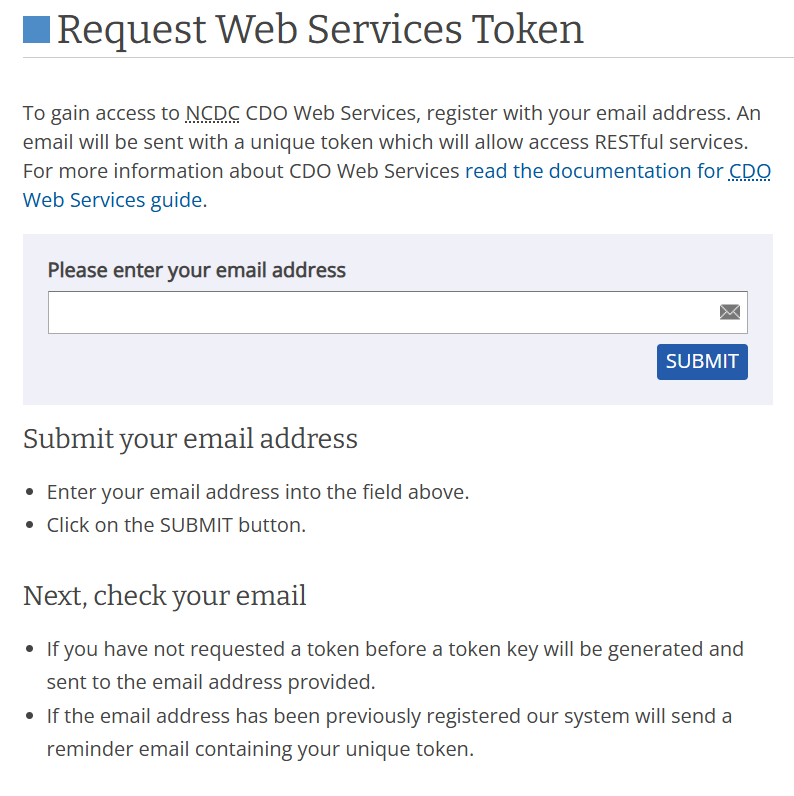

### Metadata

In [ ]:
# Define column specifications according to GHCN documentation
col_specs = [(0, 11), (12, 20), (21, 30), (31, 37), (38, 40), (41, 71), (72, 75), (76, 79)]
col_names = ["ID", "Latitude", "Longitude", "Elevation", "State", "Station Name", "GSN Flag", "HCN/CRN Flag"]

# Load the data into a pandas DataFrame
url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
noaa_stations = pd.read_fwf(url, colspecs=col_specs, names=col_names, header=None)

noaa_stations


In [ ]:
# subset for stations in Nairobi starting with obtaining bounding box 50km from centre point
nai_bbox = fs.compute_filter(nai_lat, nai_lon, 50)

In [ ]:
# Define column specifications for the country file
col_specs = [(0, 2), (3, 50)]
col_names = ["Code", "Country"]

# Load the data into a pandas DataFrame
url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-countries.txt"
noaa_countries = pd.read_fwf(url, colspecs=col_specs, names=col_names, header=None)

noaa_countries

In [ ]:
# Extract the first two characters from the 'ID' column in noaa_stations
noaa_stations['Country_Code'] = noaa_stations['ID'].str[:2]

# Merge the two dataframes based on the country codes
merged_df = pd.merge(noaa_stations, noaa_countries, left_on='Country_Code', right_on='Code', how='left')

# Display the merged dataframe
merged_df


In [ ]:
len(["DZ", "AO", "BJ", "BW", "BF", "BI", "CM", "CV", "CF", "TD", "KM", "CD", "CG", "CI",
    "DJ", "EG", "GQ", "ER", "SZ", "ET", "GA", "GM", "GH", "GN", "GW", "KE", "LS", "LR",
    "LY", "MG", "MW", "ML", "MR", "MU", "YT", "MA", "MZ", "NA", "NE", "NG", "RE", "RW",
    "ST", "SN", "SC", "SL", "SO", "ZA", "SS", "SD", "TZ", "TG", "TN", "UG", "EH", "ZM", "ZW"
])

In [ ]:
import pycountry

african_countries = [country.name for country in pycountry.countries if country.alpha_2 in [
    "DZ", "AO", "BJ", "BW", "BF", "BI", "CM", "CV", "CF", "TD", "KM", "CD", "CG", "CI",
    "DJ", "EG", "GQ", "ER", "SZ", "ET", "GA", "GM", "GH", "GN", "GW", "KE", "LS", "LR",
    "LY", "MG", "MW", "ML", "MR", "MU", "YT", "MA", "MZ", "NA", "NE", "NG", "RE", "RW",
    "ST", "SN", "SC", "SL", "SO", "ZA", "SS", "SD", "TZ", "TG", "TN", "UG", "EH", "ZM", "ZW"
]]

print(african_countries)


Stations Distributions in the world

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add world map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Plot the NOAA stations
ax.scatter(noaa_stations['Longitude'], noaa_stations['Latitude'], s=0.9, alpha=.8, transform=ccrs.PlateCarree())
plt.show()


### Extract Weather Data

In [ ]:
noaa_token = config['noaa_stations_token']
def noaa_station_data(station_id, start_date, end_date, token=noaa_token):
    url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": token}

    # Convert date strings to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    all_data = []  # Store all results

    # Process data in yearly chunks
    current_start = start_date
    while current_start <= end_date:
        current_end = min(datetime(current_start.year, 12, 31), end_date)
        print(f"Processing {current_start} - {current_end}")
        params = {
            "datasetid": "GHCND",
            "stationid": f'GHCND:{station_id}',
            "startdate": current_start.strftime("%Y-%m-%d"),
            "enddate": current_end.strftime("%Y-%m-%d"),
            "limit": 1000,
            "offset": 1
        }

        while True:
            response = requests.get(url, headers=headers, params=params)

            if response.status_code != 200:
                print(f"Error: {response.status_code}, {response.text}")
                break

            data = response.json()

            if 'results' in data and data['results']:
                all_data.extend(data['results'])  # Append new data
                params["offset"] += 1000  # Move to the next batch
            else:
                break  # Exit loop when no more data is returned

        # Move to the next year
        current_start = current_end + timedelta(days=1)

    if all_data:
        df = pd.DataFrame(all_data)
        df = df.pivot(index='date', columns='datatype', values='value')
        df.index.name = 'Date'
        return df
    else:
        print("No data retrieved")
        return None


In [ ]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import time

def extract_weather_data(station_ids, start_date, end_date, token):
    """
    Extracts and processes weather data for a list of stations in monthly chunks,
    converting raw values to standard units.

    Args:
        station_ids (list): A list of station IDs.
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.
        token (str): NOAA API token for authentication.

    Returns:
        dict: A dictionary where keys are variable names and values are dataframes
              containing the corresponding data for all stations.
    """

    # Convert start and end dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    variable_dfs = {}  # Dictionary to store dataframes for each variable

    for station_id in tqdm(station_ids, desc="Processing Stations"):
        current_start = start_date

        while current_start <= end_date:
            current_end = current_start + timedelta(days=30)
            if current_end > end_date:
                current_end = end_date

            try:
                # Fetch station data for the current month
                station_data = noaa_station_data(
                    station_id,
                    current_start.strftime('%Y-%m-%d'),
                    current_end.strftime('%Y-%m-%d'),
                    token
                )

                if station_data is not None:
                    # Convert raw values to standard units
                    for col in station_data.columns:
                        if col == 'PRCP':
                            # Convert tenths of mm to mm
                            station_data[col] = station_data[col] / 10.0
                        elif col in ['TMAX', 'TMIN']:
                            # Convert tenths of degrees Celsius to degrees Celsius
                            station_data[col] = station_data[col] / 10.0

                        # Append station ID to the dataframe
                        station_data['ID'] = station_id

                        # Add to the corresponding variable dataframe
                        if col not in variable_dfs:
                            variable_dfs[col] = pd.DataFrame()
                        variable_dfs[col] = pd.concat(
                            [variable_dfs[col], station_data[['ID', col]]]
                        )

                # Respect API rate limits by adding a delay between requests
                time.sleep(1)  # Adjust the sleep time as needed

            except Exception as e:
                print(f"Error processing station {station_id} for period "
                      f"{current_start.strftime('%Y-%m-%d')} to "
                      f"{current_end.strftime('%Y-%m-%d')}: {e}")
                continue  # Skip to the next time period in case of error

            # Move to the next month
            current_start = current_end + timedelta(days=1)

    return variable_dfs


### Nairobi Region

In [ ]:
gh_stations = subset_stations_in_bbox(noaa_stations, bbox_from_polygon('Ghana', maps_key=maps_key))

# rename id to code and latitude to lat, longitude to lon
gh_stations = gh_stations.rename(columns={'ID': 'code', 'Latitude': 'lat', 'Longitude': 'lon'})
gh_stations

In [ ]:
# !git clone https://github.com/scotthosking/get-station-data.git

In [ ]:
import sys

sys.path.append('get-station-data')

from get_station_data import ghcnd
from get_station_data.util import nearest_stn

%matplotlib inline

In [ ]:
stn_md = ghcnd.get_stn_metadata()

In [ ]:
def subset_stations_by_country(country_code):
    return stn_md[stn_md['station'].str.startswith(country_code)]

# Get the stations in Ghana
gh_noaa_stations = subset_stations_by_country('GH')

In [ ]:
plot_stations_folium([gh_noaa_stations, stations_met], ['red', 'blue'])

In [ ]:
df = ghcnd.get_data(gh_noaa_stations)

df.head()

In [ ]:
var = 'PRCP'   # precipitation
df_pr = df[ df['element'] == var ]

### Tidy up columns
df_pr = df_pr.rename(index=str, columns={"value": var})
df_pr = df_pr.drop(['element'], axis=1)

df_pr.head()

In [ ]:
tavg_var = 'TAVG'   # average temperature
df_tavg = df[ df['element'] == tavg_var ]
df_tavg = df_tavg.rename(index=str, columns={"value": tavg_var})
df_tavg = df_tavg.drop(['element'], axis=1)

tmax_var = 'TMAX'   # maximum temperature
df_tmax = df[ df['element'] == tmax_var ]
df_tmax = df_tmax.rename(index=str, columns={"value": tmax_var})
df_tmax = df_tmax.drop(['element'], axis=1)

tmin_var = 'TMIN'   # minimum temperature
df_tmin = df[ df['element'] == tmin_var ]
df_tmin = df_tmin.rename(index=str, columns={"value": tmin_var})
df_tmin = df_tmin.drop(['element'], axis=1)


In [ ]:
# @title date vs PRCP

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['PRCP']/10

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_pr.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('station')):
  _plot_series(series, series_name, i)
  fig.legend(title='station', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('PRCP')

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['TMIN']/10
# Plot the temperature data
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_tmin.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('station')):
    _plot_series(series, series_name, i)
    fig.legend(title='station', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('TAVG')

In [ ]:
df_tmax

In [ ]:
noaa_extracts_nai['PRCP'].pivot_table(
    index='date',  # Explicitly set the index to date
    columns='station_id',
    values='value',
    aggfunc='mean'  # Aggregate values by taking the mean if duplicates exist
).plot()

In [ ]:
noaa_extracts_nai['PRCP']

In [ ]:
noaa_extracts_nai['PRCP'].pivot(columns='ID', values='PRCP').plot()

In [ ]:

fig, axes = plt.subplots(len(noaa_extracts_nai), 1, sharex=True, figsize=(12, 7))

# pop the TAVG key
# noaa_extracts_nai.pop('TAVG')

# Iterate over each variable (PRCP, TAVG, TMAX, TMIN)
for i, (key, df) in enumerate(noaa_extracts_nai.items()):
  if key == 'TAVG':
    continue
  # Pivot the DataFrame to have stations as columns
  pivot_df = df.pivot(columns='ID', values=key)

  # Plot the data for the current variable
  ax = axes[i] if len(noaa_extracts_nai) > 1 else axes # Handle single or multiple subplots
  pivot_df.plot(ax=ax, legend=True)  # Use a shared x-axis
  ax.set_ylabel(key)
  ax.set_title(key)

  # Clear index for x-axis
  ax.xaxis.grid(True, which='minor')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Kampala Region

In [ ]:
kampala_stations_noaa = subset_stations_in_bbox(noaa_stations, kampala_bbox)
kampala_stations_noaa

### Kigali Region

In [ ]:
kigali_stations_noaa = subset_stations_in_bbox(noaa_stations, kigali_bbox)
kigali_stations_noaa

In [ ]:
noaa_extracts_kigali = extract_weather_data(kigali_stations_noaa['ID'], '2023-01-01', '2023-12-31')

In [ ]:
# Extract station in a particular region

fig, axes = plt.subplots(len(noaa_extracts_kigali), 1, sharex=True, figsize=(12, 7))

# Iterate over each variable (PRCP, TAVG, TMAX, TMIN)
for i, (key, df) in enumerate(noaa_extracts_kigali.items()):
  # Pivot the DataFrame to have stations as columns
  pivot_df = df.pivot(columns='ID', values=key)

  # Plot the data for the current variable
  ax = axes[i] if len(noaa_extracts_nai) > 1 else axes # Handle single or multiple subplots
  pivot_df.plot(ax=ax, legend=True)  # Use a shared x-axis
  ax.set_ylabel(key)
  ax.set_title(key)

  # Clear index for x-axis
  ax.xaxis.grid(True, which='minor')

# Improve x-axis readability (optional)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Have a look at your Data
To do this ensure you have metadata for your ground stations with the column <BR>
**Station ID | Longitude | Latitude**

The second dataset needs to containig the variables you need to plot which would contain a time series data <br>
**Date column | Station 1 | Station 2 | Station 3 ..... Station n**
<br>n being the numer of stations

In [ ]:
# ToDo Get to know your data

data_path = ... # Path to your dataset for the given variable

# Load using pandas

# Subset for the given region you want

# Plot the variable data

## Temperature CBAM (Nairobi and Kampala) and ERA5 (Kigali)

### Extract CBAM Avg Temperature and visualise

In [ ]:
# Initialize client and fetch data
cbam_client = CBAMClient('config.json')  # Ensure config.json contains only username and password

# Define parameters
kampala_bbox_str = f"{kampala_bbox[1]},{kampala_bbox[0]},{kampala_bbox[3]}, {kampala_bbox[2]}"
start_date = "2023-01-01"
end_date = "2023-12-31"
attributes = "min_temperature"
product = 'cbam_historical_analysis_bias_adjust'

# Minimum temperature
csv_min_te = cbam_client.get_data(kampala_bbox_str, start_date, end_date, attributes, product=product)
cbam_min_te = pd.read_csv(io.StringIO(csv_min_te))

# convert date column to datetime and sort
cbam_min_te['date'] = pd.to_datetime(cbam_min_te['date'])
cbam_min_te = cbam_min_te.sort_values('date')

# set date as index
cbam_min_te = cbam_min_te.set_index('date')

# Maximum Temperature
attributes = "max_temperature"
csv_max_te = cbam_client.get_data(kampala_bbox_str, start_date, end_date, attributes, product=product)
cbam_max_te = pd.read_csv(io.StringIO(csv_max_te))

# convert date column to datetime
cbam_max_te['date'] = pd.to_datetime(cbam_max_te['date'])
cbam_max_te = cbam_max_te.sort_values('date')

# set date as index
cbam_max_te = cbam_max_te.set_index('date')

# Calculate the average temperature
cbam_avg_temp = (cbam_min_te['min_temperature'] + cbam_max_te['max_temperature']) / 2

# reset the index
cbam_avg_temp = cbam_avg_temp.reset_index()

# rename the column
cbam_avg_temp = cbam_avg_temp.rename(columns={0: 'avg_temperature'})

In [ ]:
# Reset the index before merging on columns
cbam_max_te = cbam_max_te.reset_index()
cbam_min_te = cbam_min_te.reset_index()

# Perform the merge
merged_cbam_data = pd.merge(cbam_max_te, cbam_min_te, on=['date', 'lat', 'lon'], how='inner')

# compute the average of merged_cbam_data
merged_cbam_data['avg_temperature'] = (merged_cbam_data['max_temperature'] + merged_cbam_data['min_temperature']) / 2
# convert the dataframe to xarray
cbam_avg_ds = df_to_xarray(merged_cbam_data, values='avg_temperature')



In [ ]:
selected_data = select(cbam_avg_ds, "avg_temperature", level=None, max_steps=None)
scaled_data, norm, cmap = scale(selected_data, robust=True)

# Prepare the data dictionary for plotting.
data_for_plot = {"Average Temperature": (scaled_data, norm, cmap)}
fig_title = "Average Temperature in Kampala"



# Plot and display the animation in the notebook.
html_anim = plot_data(data_for_plot, fig_title, plot_size=7, robust=True, extent=[kampala_bbox[1],kampala_bbox[0],kampala_bbox[3], kampala_bbox[2]])
display(html_anim)

### Nairobi Region Average Temperature

In [ ]:
def extract_avg_temp(client, bbox, start_date, end_date, product='cbam_historical_analysis_bias_adjust'):
    """
    Extracts and calculates the average temperature from CBAM data for a given bounding box and time period.

    Args:
        client: The CBAM client instance.
        bbox: The bounding box coordinates.
        start_date: The start date string (YYYY-MM-DD).
        end_date: The end date string (YYYY-MM-DD).
        product: The product name (default: 'cbam_historical_analysis_bias_adjust').

    Returns:
        pandas.DataFrame: A DataFrame containing the average temperature, or None if an error occurs.
    """
    bbox_str = f"{bbox[1]},{bbox[0]},{bbox[3]}, {bbox[2]}"

    try:
        # Minimum temperature
        csv_min_te = client.get_data(bbox_str, start_date, end_date, "min_temperature", product=product)
        cbam_min_te = pd.read_csv(io.StringIO(csv_min_te))
        cbam_min_te['date'] = pd.to_datetime(cbam_min_te['date'])
        cbam_min_te = cbam_min_te.sort_values('date')

        # Maximum Temperature
        csv_max_te = client.get_data(bbox_str, start_date, end_date, "max_temperature", product=product)
        cbam_max_te = pd.read_csv(io.StringIO(csv_max_te))
        cbam_max_te['date'] = pd.to_datetime(cbam_max_te['date'])
        cbam_max_te = cbam_max_te.sort_values('date')

        # Merge and calculate average
        merged_cbam_data = pd.merge(cbam_max_te, cbam_min_te, on=['date', 'lat', 'lon'], how='inner')
        merged_cbam_data['avg_temperature'] = (merged_cbam_data['max_temperature'] + merged_cbam_data['min_temperature']) / 2

        return merged_cbam_data

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [ ]:
# get the bounding box for kampala region
nai_bbox = fs.compute_filter(nai_lat, nai_lon, 50)

In [ ]:
nai_avg_temp = extract_avg_temp(cbam_client, nai_bbox, '2023-01-01', '2023-12-31')
cbam_avg_ds_nai = df_to_xarray(nai_avg_temp, values='avg_temperature')

In [ ]:
selected_data = select(cbam_avg_ds_nai, "avg_temperature", level=None, max_steps=None)
scaled_data, norm, cmap = scale(selected_data, robust=True)

# Prepare the data dictionary for plotting.
data_for_plot = {"Average Temperature": (scaled_data, norm, cmap)}
fig_title = "Average Temperature in Nairobi"

# Plot and display the animation in the notebook.
html_anim = plot_data(data_for_plot, fig_title, plot_size=7, robust=True, extent=[kampala_bbox[1],kampala_bbox[0],kampala_bbox[3], kampala_bbox[2]])
display(html_anim)

### Extract ERA5 2m Temperature and visualise

In [ ]:
# from the variables data frame  extracted earlier plot the 2m temperature in Kigali

variable_dataframes['temperature_2m']['value'] = variable_dataframes['temperature_2m']['value'] -273.15
# rename latitude to lat and longitude to lon
variable_dataframes['temperature_2m'].rename(columns={'latitude': 'lat', 'longitude': 'lon'}, inplace=True)
# rename value to total_precipitation
variable_dataframes['temperature_2m'].rename(columns={'value': 'temperature_2m'}, inplace=True)
eraf_te_xr = df_to_xarray(variable_dataframes['temperature_2m'], 'temperature_2m')

In [ ]:
selected_data = select(eraf_te_xr, "temperature_2m", level=None, max_steps=None)
scaled_data, norm, cmap = scale(selected_data, robust=True)

# Prepare the data dictionary for plotting.
data_for_plot = {"Surface Temperature": (scaled_data, norm, cmap)}
fig_title = "ERA5 Surface  Temperature Kigali Region"

# Plot and display the animation in the notebook.
html_anim = plot_data(data_for_plot, fig_title, plot_size=7, robust=True, extent=[kigali_bbox[1],kigali_bbox[0], kigali_bbox[3], kigali_bbox[2]])
display(html_anim)

## ERA5  Data from 1980
1. Extract monthly aggregates of the data
2. Have a matrix of months against the years to look at the trend of the months


### ERA5 monthly data

In [ ]:
import datetime
# extract montly data
def extract_era5_monthly(start_date_str, end_date_str, bbox=None, polygon=None,
                         region_name=None, maps_key='', era5_land=False):
    """
    Extract ERA5 reanalysis data from Google Earth Engine for a given bounding box and date range.
    The extraction is performed in monthly chunks at a 0.25° resolution. For each month, the image
    is aggregated (mean) and a 'date' property is added. The function then uses sampleRectangle to extract
    pixel-level values from the monthly aggregated image and converts the results into multiple pandas DataFrames—one for each variable.
    Each DataFrame has the columns: date, latitude, longitude, and value (the pixel value for that variable).

    Args:
        start_date_str (str): Start date in 'YYYY-MM-DD' format.
        end_date_str (str): End date in 'YYYY-MM-DD' format.
        bbox (list or tuple): Bounding box specified as [minLon, minLat, maxLon, maxLat].

    Returns:
        dict: A dictionary where keys are variable (band) names and values are pandas DataFrames containing
              the time series data. Each DataFrame includes columns: 'date', 'latitude', 'longitude', 'value'.
    """
    # Convert input dates from strings to datetime objects.
    start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date   = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

    # Define the geometry from the bounding box.
    if bbox is not None:
        region = ee.Geometry.Rectangle(bbox)
    elif region_name is not None:
        geojson = get_region_geojson(region_name, maps_key)
        if geojson is None:
            return None
        region = ee.Geometry.Polygon(geojson['geometry']['coordinates'][0])
    else:

        region = ee.Geometry.Polygon(polygon)

    # Use a scale (in meters) corresponding to ~0.25° at the equator.
    scale_m = 27830

    # This dictionary will accumulate results for each band (variable).
    results = {}

    # Loop over months between start_date and end_date.
    current = start_date
    while current < end_date:
        print(f"Processing {current.strftime('%Y-%m-%d')} to {(current + datetime.timedelta(days=29)).strftime('%Y-%m-%d')}")
        # Determine the first day of the next month.
        if current.month == 12:
            next_month = datetime.datetime(current.year + 1, 1, 1)
        else:
            next_month = datetime.datetime(current.year, current.month + 1, 1)

        # Convert Python dates to Earth Engine date objects.
        ee_start = ee.Date(current.strftime('%Y-%m-%d'))
        ee_end   = ee.Date(next_month.strftime('%Y-%m-%d'))

        # Extract from ERA5 Land if era5_land is True, otherwise use ERA5.
        if era5_land:
            # If ER5 Land (0.1) or ERA5 (0.25) is used
            era5_collection = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
                            .filterDate(ee_start, ee_end) \
                           .filterBounds(region)
        else:
            # Get the ERA5 hourly image collection for the current day.
            era5_collection = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
                            .filterDate(ee_start, ee_end) \
                           .filterBounds(region)

        # Aggregate the daily images for the month by taking their mean.
        monthly_image = era5_collection.mean()

        # Add a property for the date (here the start of the month).
        monthly_date_str = current.strftime('%Y-%m-%d')
        monthly_image = monthly_image.set('date', monthly_date_str)

        # Use sampleRectangle to extract pixel values from the monthly image
        # instead of getRegion, which works with ImageCollections.
        region_data = monthly_image.sampleRectangle(region=region, properties=['date'], defaultValue=0).getInfo()

        # Extract properties from region_data and organize into a list of dictionaries
        properties = region_data['properties']
        band_names = [band for band in properties if band not in ['date']]

        # Accessing coordinates for the bounding box
        coordinates = region_data['geometry']['coordinates'][0]

        # Creating latitude and longitude grids for the bounding box
        lons = np.linspace(coordinates[0][0], coordinates[2][0], len(properties[band_names[0]][0]))  # Assuming properties structure
        lats = np.linspace(coordinates[0][1], coordinates[2][1], len(properties[band_names[0]]))

        # Extract data for each band
        data = []
        for i, lat in enumerate(lats):
            for j, lon in enumerate(lons):
                row_data = {
                    'date': properties['date'],
                    'latitude': lat,
                    'longitude': lon
                }
                for band in band_names:
                    try:
                        # Accessing band data using i and j indices
                        row_data[band] = properties[band][i][j]
                    except IndexError:
                        # Handle IndexError by assigning NaN and printing a message
                        row_data[band] = np.nan
                        print(f"IndexError encountered for band '{band}' at coordinates ({lat}, {lon}). Assigning NaN.")
                data.append(row_data)


        # Convert data to pandas DataFrame
        df = pd.DataFrame(data)

        # If results dictionary is empty, initialize with current variable's DataFrame
        if not results:
            results = {col: pd.DataFrame(columns=['date', 'latitude', 'longitude', 'value']) for col in df.columns if col not in ['date', 'latitude', 'longitude']}

        # Append data to existing DataFrames in results dictionary
        for var_name in results:
            temp_df = df[['date', 'latitude', 'longitude', var_name]].copy()
            temp_df.rename(columns={var_name: 'value'}, inplace=True)
            results[var_name] = pd.concat([results[var_name], temp_df], ignore_index=True)

        # Move to the next month.
        current = next_month

    return results

### Accra

In [ ]:
# Get Accra Coordinates
accra_lat, accra_lon = fs.centre_point('Accra')
# Get 70 km within kigali region
accra_bbox = fs.compute_filter(accra_lat, accra_lon, 100)


In [ ]:
# Define the bounding box as [minLon, minLat, maxLon, maxLat]
accra_mon_bbox = [accra_bbox[1], accra_bbox[0], accra_bbox[3], accra_bbox[2]]
print(accra_mon_bbox)
# Define the extraction period.
start_date = '1980-01-01'
end_date   = '2020-06-01'  # One monthly chunk for demonstration

# Call the extraction function.
accra_variable_dataframes = extract_era5_monthly(start_date, end_date, region_name='Ghana', maps_key=maps_key)

# Print a summary of the results.
for var, df in accra_variable_dataframes.items():
    print(f"\nData for variable '{var}':")
    print(df.head())

In [ ]:
TE = accra_variable_dataframes['mean_2m_air_temperature']

In [ ]:
accra_te = accra_variable_dataframes['mean_2m_air_temperature']
# convert date to datetime
accra_te.date = pd.to_datetime(accra_te.date)

# divide by 30 and then subtract 273.15 from value column
# kigali_te.value = kigali_te.value / 30
accra_te.value = accra_te.value - 273.15

# extract year and month
accra_te['year'] = accra_te['date'].dt.year
accra_te['month'] = accra_te['date'].dt.month




In [ ]:
import seaborn as sns

In [ ]:
# pivot table for heatmap
te_heatmap_data = accra_te.pivot_table(index='month', columns='year', values='value', aggfunc='mean')

# Set style
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

# Create Heatmap
ax = sns.heatmap(
    te_heatmap_data,
    cmap="coolwarm",  # Choose a visually appealing colormap
    annot=False,        # Show values inside the cells
    fmt=".1f",         # Formatting numbers
    linewidths=0.5,    # Add grid lines
    linecolor="white",
    cbar_kws={'label': 'Value Intensity'}
)

# Beautify Labels
ax.set_title("Monthly Temperature Value Ghana Trends Over Years", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Month", fontsize=11)
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xticks(rotation=45)

# Show plot
plt.show()

In [ ]:
accra_pr = accra_variable_dataframes['total_precipitation']
# convert date to datetime
accra_pr.date = pd.to_datetime(accra_pr.date)

# multiply the value column with 1000
accra_pr.value = accra_pr.value * 30

accra_pr

In [ ]:
# Extract Year and Month
accra_pr['year'] = accra_pr['date'].dt.year
accra_pr['month'] = accra_pr['date'].dt.month

# Pivot Table for Heatmap
heatmap_data = accra_pr.pivot_table(index='month', columns='year', values='value', aggfunc='mean')


In [ ]:
# Set style
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

# Create Heatmap
ax = sns.heatmap(
    heatmap_data,
    cmap="coolwarm",  # Choose a visually appealing colormap
    annot=False,        # Show values inside the cells
    fmt=".1f",         # Formatting numbers
    linewidths=0.5,    # Add grid lines
    linecolor="white",
    cbar_kws={'label': 'Value Intensity'}
)

# Beautify Labels
ax.set_title("Monthly Rainfall Value Ghana Trends Over Years", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Month", fontsize=11)
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xticks(rotation=45)

# Show plot
plt.show()


### Zimbabwe

In [ ]:
# Define the extraction period.
start_date = '1980-01-01'
end_date   = '2020-06-01'  # One monthly chunk for demonstration

# Call the extraction function.
zw_variable_dataframes = extract_era5_monthly(start_date, end_date, region_name='Zimbabwe', maps_key=maps_key)

# Print a summary of the results.
for var, df in zw_variable_dataframes.items():
    print(f"\nData for variable '{var}':")
    print(df.head())

In [ ]:
# zw_te = zw_variable_dataframes['mean_2m_air_temperature']
# # convert date to datetime
# zw_te.date = pd.to_datetime(zw_te.date)

# # divide by 30 and then subtract 273.15 from value column
# # kigali_te.value = kigali_te.value / 30
# zw_te.value = zw_te.value - 273.15

# # extract year and month
# zw_te['year'] = zw_te['date'].dt.year
# zw_te['month'] = zw_te['date'].dt.month

# pivot table for heatmap
te_heatmap_data = zw_te.pivot_table(index='month', columns='year', values='value', aggfunc='mean')

# Set style
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

# Create Heatmap
ax = sns.heatmap(
    te_heatmap_data,
    cmap="coolwarm",  # Choose a visually appealing colormap
    annot=False,        # Show values inside the cells
    fmt=".1f",         # Formatting numbers
    linewidths=0.5,    # Add grid lines
    linecolor="white",
    cbar_kws={'label': 'Value Intensity'}
)

# Beautify Labels
ax.set_title("Zimbabwe Monthly Temperature Value Trends Over Years", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Month", fontsize=11)
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xticks(rotation=45)

# Show plot
plt.show()


In [ ]:
zw_pr = zw_variable_dataframes['total_precipitation']
# convert date to datetime
zw_pr.date = pd.to_datetime(zw_pr.date)

# multiply the value column with 1000
zw_pr.value = zw_pr.value * 30000


# Extract Year and Month
zw_pr['year'] = zw_pr['date'].dt.year
zw_pr['month'] = zw_pr['date'].dt.month

# Pivot Table for Heatmap
heatmap_data = zw_pr.pivot_table(index='month', columns='year', values='value', aggfunc='mean')
# Set style
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

# Create Heatmap
ax = sns.heatmap(
    heatmap_data,
    cmap="coolwarm",  # Choose a visually appealing colormap
    annot=False,        # Show values inside the cells
    fmt=".1f",         # Formatting numbers
    linewidths=0.5,    # Add grid lines
    linecolor="white",
    cbar_kws={'label': 'Value Intensity'}
)

# Beautify Labels
ax.set_title("Zimbabwe Monthly Rainfall Value Trends Over Years", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Month", fontsize=11)
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xticks(rotation=45)

# Show plot
plt.show()



### Kampala

In [ ]:
# Define the bounding box as [minLon, minLat, maxLon, maxLat]
kampala_mon_bbox = [kampala_bbox[1], kampala_bbox[0], kampala_bbox[3], kampala_bbox[2]]
print(kampala_mon_bbox)
# Define the extraction period.
start_date = '1980-01-01'
end_date   = '2020-06-01'  # One monthly chunk for demonstration

# Call the extraction function.
kampala_variable_dataframes = extract_era5_monthly(start_date, end_date, kampala_mon_bbox)

# Print a summary of the results.
for var, df in kampala_variable_dataframes.items():
    print(f"\nData for variable '{var}':")
    print(df.head())

#### Temperature

In [ ]:
kamp_te = kampala_variable_dataframes['mean_2m_air_temperature']
# convert date to datetime
kamp_te.date = pd.to_datetime(kamp_te.date)

# divide by 30 and then subtract 273.15 from value column
# kigali_te.value = kigali_te.value / 30
kamp_te.value = kamp_te.value - 273.15

# extract year and month
kamp_te['year'] = kamp_te['date'].dt.year
kamp_te['month'] = kamp_te['date'].dt.month

# pivot table for heatmap
te_heatmap_data = kamp_te.pivot_table(index='month', columns='year', values='value', aggfunc='mean')

# Set style
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

# Create Heatmap
ax = sns.heatmap(
    te_heatmap_data,
    cmap="coolwarm",  # Choose a visually appealing colormap
    annot=False,        # Show values inside the cells
    fmt=".1f",         # Formatting numbers
    linewidths=0.5,    # Add grid lines
    linecolor="white",
    cbar_kws={'label': 'Value Intensity'}
)

# Beautify Labels
ax.set_title("Monthly Temperature Value Trends Over Years", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Month", fontsize=11)
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xticks(rotation=45)

# Show plot
plt.show()


#### Rainfall

In [ ]:
kamp_pr = kampala_variable_dataframes['total_precipitation']
# convert date to datetime
kamp_pr.date = pd.to_datetime(kamp_pr.date)

# multiply the value column with 1000
kamp_pr.value = kamp_pr.value * 1000


# Extract Year and Month
kamp_pr['year'] = kamp_pr['date'].dt.year
kamp_pr['month'] = kamp_pr['date'].dt.month

# Pivot Table for Heatmap
heatmap_data = kamp_pr.pivot_table(index='month', columns='year', values='value', aggfunc='mean')
# Set style
plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid")

# Create Heatmap
ax = sns.heatmap(
    heatmap_data,
    cmap="coolwarm",  # Choose a visually appealing colormap
    annot=False,        # Show values inside the cells
    fmt=".1f",         # Formatting numbers
    linewidths=0.5,    # Add grid lines
    linecolor="white",
    cbar_kws={'label': 'Value Intensity'}
)

# Beautify Labels
ax.set_title("Monthly Rainfall Value Trends Over Years", fontsize=14, fontweight="bold")
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Month", fontsize=11)
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xticks(rotation=45)

# Show plot
plt.show()



## Is there an increase or decrease of extreme events in the last 40 years?
1. Nairobi
2. Kampala
3. Kigali

A comparison of TAMSAT, CHIRPS and ERA5 flash floods risk and heatwave from ERA5 data and CBAM <br>
We define an extreme event as the data occureence that is the 98th percentile and increasing or decreasing we compare the total number for a given year.

### Kigali Extreme Events

In [ ]:
def analyze_extreme_events(df, column_name, percentile=98):
    """
    Analyzes the increase or decrease of extreme events over time,
    using a threshold computed from the entire dataset (e.g., last 40 years).

    Args:
        df: DataFrame with a 'year' column and a data column.
        column_name: The name of the data column to analyze.
        percentile: The percentile to define extreme events (default: 98th).

    Returns:
        A dictionary with the number of extreme events per year.
    """
    # Compute a global threshold using the entire dataset
    global_threshold = np.percentile(df[column_name], percentile)
    print("Global threshold ({}th percentile): {:.3f}".format(percentile, global_threshold))

    extreme_events_per_year = {}
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year][column_name]
        print(f"Year {year}: {len(year_data)} data points") if year_data
        extreme_events_per_year[year] = (year_data >= global_threshold).sum()
    return extreme_events_per_year

# Kigali temperature data:
kigali_extreme_temp = analyze_extreme_events(kigali_te, 'value')
print(kigali_extreme_temp)

#  Kigali precipitation data:
kigali_extreme_prcp = analyze_extreme_events(kigali_pr, 'value')
print(kigali_extreme_prcp)


In [ ]:
def plot_extreme_events(data, title, ylabel):
    """
    Plots the number of extreme events over time.

    Args:
        data: A dictionary where keys are years and values are the number of extreme events.
        title: The title of the plot.
        ylabel: The label for the y-axis.
    """
    years = list(data.keys())
    extreme_event_counts = list(data.values())
    plt.figure(figsize=(12, 6))
    plt.bar(years, extreme_event_counts, color='skyblue')
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Kigali precipitation
plot_extreme_events(kigali_extreme_prcp, "Extreme Precipitation Events in Kigali (98th Percentile)", "Number of Extreme Precipitation Events")

# Kigali Temperature
plot_extreme_events(kigali_extreme_temp, "Extreme Temperature Events in Kigali (98th Percentile)", "Number of Extreme Temperature Events")

### Nairobi Extreme events

In [ ]:
# Nairobi temperature data:
nai_extreme_temp = analyze_extreme_events(nai_te, 'value')
print(nai_extreme_temp)

#  Nairobi precipitation data:
nai_extreme_prcp = analyze_extreme_events(nai_pr, 'value')
print(nai_extreme_prcp)

In [ ]:
# Kigali precipitation
plot_extreme_events(nai_extreme_prcp, "Extreme Precipitation Events in Nairobi (98th Percentile)", "Number of Extreme Precipitation Events")

# Kigali Temperature
plot_extreme_events(nai_extreme_temp, "Extreme Temperature Events in Nairobi (98th Percentile)", "Number of Extreme Temperature Events")

### Kampala Extreme Events

In [ ]:
# Kigali temperature data:
kamp_extreme_temp = analyze_extreme_events(kamp_te, 'value')
print(kamp_extreme_temp)

#  Kigali precipitation data:
kamp_extreme_prcp = analyze_extreme_events(kamp_pr, 'value')
print(kigali_extreme_prcp)

In [ ]:
# Kigali precipitation
plot_extreme_events(kamp_extreme_prcp, "Extreme Precipitation Events in Kampala (98th Percentile)", "Number of Extreme Precipitation Events")

# Kigali Temperature
plot_extreme_events(kamp_extreme_temp, "Extreme Temperature Events in Kampala (98th Percentile)", "Number of Extreme Temperature Events")

## Looking at Yield
1. Using FAOSTAT
2. Using GDHY to get the regional yield at regional level for maize, rice, wheat and soybeans

### FAOSTAT
A database of the United Nations

In [ ]:
country = "Ghana"
crop = "Cocoa"
start_year = 1980
end_year = 2025

yield_data = fetch_yield_data(country, crop, start_year, end_year)
if yield_data is not None:
    print(yield_data)

In [ ]:
# Aggregate the df_pr and df_tmax as one station and have the yearly data for pr and tmax
summ_gh_pr = df_pr.pivot(
    index='date',
    values='PRCP',
    columns='station'
).sum(axis=1).resample('Y').sum()

summ_gh_tmax = df_tmax.pivot(
    index='date',
    values='TMAX',
    columns='station'
).mean(axis=1).resample('Y').mean()

summ_gh_tmin = df_tmin.pivot(
    index='date',
    values='TMIN',
    columns='station'
).mean(axis=1).resample('Y').mean()

In [ ]:
# @title Year vs Yield

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Year']
  ys = series['Yield']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = yield_data.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Unit')):
  _plot_series(series, series_name, i)
  fig.legend(title='Unit', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
plt.xticks(rotation=45)  # Rotate by 45 degrees
plt.title(f'{crop} Yield in {country} from {yield_data.Year.iloc[0]} to {yield_data.Year.iloc[-1]}')
plt.tight_layout()
_ = plt.ylabel('Yield')

In [ ]:
# Filter yield data to include only the rows in metric tons (t)
df_yield_t = yield_data[yield_data['Unit'] == 't'][['Year','Yield']].copy()
df_yield_t['Year'] = pd.to_numeric(df_yield_t['Year'], errors='coerce')

# Convert the yearly Series (summ_gh_pr, summ_gh_tmax, summ_gh_tmin) to DataFrames
df_pr2 = summ_gh_pr.reset_index()
df_pr2['Year'] = df_pr2['date'].dt.year
df_pr2 = df_pr2[['Year', 'PRCP']]

df_tmax2 = summ_gh_tmax.reset_index()
df_tmax2['Year'] = df_tmax2['date'].dt.year
df_tmax2 = df_tmax2[['Year', 'TMAX']]

df_tmin2 = summ_gh_tmin.reset_index()
df_tmin2['Year'] = df_tmin2['date'].dt.year
df_tmin2 = df_tmin2[['Year', 'TMIN']]

# Merge them by Year
df_merged = (
    df_yield_t.merge(df_pr2, on='Year', how='left')
              .merge(df_tmax2, on='Year', how='left')
              .merge(df_tmin2, on='Year', how='left')
)

# Reshape for heatmap: rows = variables, columns = years
df_melt = df_merged.melt(id_vars='Year', var_name='Variable', value_name='Value')
heatmap_data = df_melt.dropna().pivot(index='Variable', columns='Year', values='Value')

# Plot the heatmap (Seaborn and matplotlib are already imported)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Heatmap of Yield (t), PRCP, TMAX, and TMIN by Year")
plt.show()

In [ ]:
# for yield data select the units with t
yield_data = yield_data[yield_data['Unit'].str.contains('t')]

In [ ]:
# Convert 'yield_data' to match the size and index with 'summ_gh_pr', 'summ_gh_tmax', 'summ_gh_tmin'.
df_merge = pd.DataFrame({
    'Yield': yield_data['Yield'].values,
    'PR': summ_gh_pr.values,
    'TMAX': summ_gh_tmax.values,
    'TMIN': summ_gh_tmin.values
})
# Copy the 'Year' values from 'yield_data' into 'df_merge'
df_merge['Year'] = yield_data['Year'].values

# Handle any parsing issues by coercing invalid years to NaT
df_merge['Year'] = pd.to_datetime(df_merge['Year'], format='%Y', errors='coerce')
df_merge.dropna(subset=['Year'], inplace=True)

# Finally, set the datetime column as the index
df_merge.set_index('Year', inplace=True)

In [ ]:
# 1. Plot Aggregate Correlation Heatmap
corr_all = df_merge.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_all, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Aggregate Correlation across all Years')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

tmax_data = summ_gh_tmax    
tmin_data = summ_gh_tmin
pr_data = summ_gh_pr

# Convert index to datetime
tmax_data.index = pd.to_datetime(tmax_data.index)
tmin_data.index = pd.to_datetime(tmin_data.index)
pr_data.index = pd.to_datetime(pr_data.index)

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
fig.subplots_adjust(hspace=0.1)  # Adjusts space between plots

# Plot TMAX
axs[0].plot(tmax_data.index.year, tmax_data, color='red')
axs[0].set_ylabel('TMAX (°C)')
axs[0].set_title('Yearly Maximum Temperature')

# Plot TMIN
axs[1].plot(tmin_data.index.year, tmin_data, color='blue')
axs[1].set_ylabel('TMIN (°C)')
axs[1].set_title('Yearly Minimum Temperature')

# Plot Precipitation
axs[2].bar(pr_data.index.year, pr_data, color='green')
axs[2].set_ylabel('Precipitation (mm)')
axs[2].set_title('Yearly Precipitation')

# Plot Yield
axs[3].plot(pd.to_numeric(yield_data["Year"]), yield_data["Yield"], color='black')
axs[3].set_ylabel('Yield (tons/ha)')
axs[3].set_xlabel('Year')
axs[3].set_title('Yearly Crop Yield')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Create the mean of the xarray dataset along the time dimension yearly
def yearly_mean(ds):
    return ds.resample(time='Y').mean()

# Plot the data yearly against the yield as time series


### Global Dataset of Historical Yield (GDHY)
GDHY provides annual time series data of 0.5-degree grid-cell yield estimates for major crops worldwide, covering the period from 1981 to 2016. The dataset includes information on maize, rice, wheat, and soybean yields.

In [ ]:
# import requests, zipfile, io

# url = "https://store.pangaea.de/Publications/IizumiT_2019/gdhy_v1.2_v1.3_20190128.zip"
# response = requests.get(url)
# with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#     z.extractall(".")

In [ ]:
import os
import glob
import xarray as xr
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
from IPython.display import HTML
import xarray as xr
from IPython.display import display

def plot_data(data_dict: dict, fig_title: str, plot_size: float = 5, robust: bool = False,
              cols: int = 4, bbox: list = None, polygon: list = None) -> HTML:
    """
    Plot the provided xarray data on a map, with the plot extent defined by either a bounding box or a polygon.

    Args:
        data_dict (dict): Dictionary where keys are titles and values are tuples (data, norm, cmap).
        fig_title (str): Title of the figure.
        plot_size (float): Size factor for the figure.
        robust (bool): Whether to use robust scaling for color normalization.
        cols (int): Number of columns in the plot grid.
        bbox (list, optional): Bounding box defined as [lon_min, lon_max, lat_min, lat_max]. If provided, it defines the plot extent.
        polygon (list, optional): A list of [lon, lat] coordinates defining a polygon. If provided (and bbox is not), its bounding box is used for the plot extent.
                                  Additionally, if polygon is provided, it is overlaid on each subplot.

    Returns:
        HTML: The animation as HTML.

    Raises:
        ValueError: If neither bbox nor polygon is provided.
    """
    # Determine the plotting extent.
    if bbox is not None:
        extent = bbox
    elif polygon is not None:
        lons = [coord[0] for coord in polygon]
        lats = [coord[1] for coord in polygon]
        extent = [min(lons), max(lons), min(lats), max(lats)]
    else:
        raise ValueError("Either bbox or polygon must be provided to define the plot extent.")

    # Get first dataset to determine number of time steps.
    first_data = next(iter(data_dict.values()))[0]
    max_steps = first_data.sizes.get("time", 1)
    assert all(max_steps == d[0].sizes.get("time", 1) for d in data_dict.values())

    cols = min(cols, len(data_dict))
    rows = math.ceil(len(data_dict) / cols)
    # Use constrained_layout to automatically handle spacing.
    figure = plt.figure(figsize=(plot_size * 2 * cols, plot_size * rows), constrained_layout=True)
    figure.suptitle(fig_title, fontsize=16)

    images = []
    axes = []
    for i, (title, (plot_data_arr, norm, cmap)) in enumerate(data_dict.items()):
        ax = figure.add_subplot(rows, cols, i + 1, projection=ccrs.PlateCarree())
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, edgecolor='white')
        ax.add_feature(cfeature.OCEAN)
        # Overlay the polygon if provided.
        if polygon is not None:
            poly_patch = mpatches.Polygon(polygon, closed=True, facecolor='none',
                                          edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())
            ax.add_patch(poly_patch)
        im = ax.imshow(
            plot_data_arr.isel(time=0, missing_dims="ignore"), norm=norm,
            origin="lower", cmap=cmap, transform=ccrs.PlateCarree(), extent=extent)
        plt.colorbar(
            mappable=im,
            ax=ax,
            orientation="vertical",
            pad=0.01,       # reduced padding
            aspect=16,
            shrink=0.7,     # adjusted shrink
            extend=("both" if robust else "neither"))
        images.append(im)
        axes.append(ax)

    # Precompute slices to avoid repeated slicing in update.
    precomputed = {}
    for key, (da, norm, cmap) in data_dict.items():
        precomputed[key] = [da.isel(time=t, missing_dims="ignore") for t in range(max_steps)]

    def update(frame):
        if "time" in first_data.dims:
            date_str = pd.to_datetime(first_data["time"][frame].item()).strftime('%Y-%m-%d')
            figure.suptitle(f"{fig_title}, {date_str}", fontsize=16)
        else:
            figure.suptitle(fig_title, fontsize=16)
        for im, (title, (da, norm, cmap)) in zip(images, data_dict.items()):
            im.set_data(precomputed[title][frame])
        return images

    ani = animation.FuncAnimation(fig=figure, func=update, frames=max_steps, interval=250)
    plt.close(figure.number)
    return HTML(ani.to_jshtml())

def load_yield_data(directory_path: str) -> xr.Dataset:
    """
    Load all yield .nc4 files from the specified directory into a single xarray Dataset.

    Args:
        directory_path (str): Path to the directory containing the yield .nc4 files.

    Returns:
        xr.Dataset: Combined dataset with time dimension set based on the years in filenames.
    """
    # List all .nc4 files in the directory
    files = sorted(glob.glob(os.path.join(directory_path, 'yield_*.nc4')))
    if not files:
        raise ValueError(f"No .nc4 files found in directory: {directory_path}")

    # Extract years from filenames
    years = []
    for f in files:
        filename = os.path.basename(f)
        year_str = filename.split('_')[1].split('.')[0]
        years.append(int(year_str))

    # Open each dataset and assign the correct time coordinate
    datasets = []
    for file, year in zip(files, years):
        ds = xr.open_dataset(file)
        # Expand dimensions to include time and assign the year as a datetime
        ds = ds.expand_dims(time=[pd.Timestamp(year=year, month=1, day=1)])
        datasets.append(ds)

    # Concatenate all datasets along the time dimension
    combined_ds = xr.concat(datasets, dim='time')
    return combined_ds

def plot_yield_data(yield_ds: xr.Dataset, fig_title: str, plot_size: float = 5,
                    robust: bool = False, cols: int = 1, bbox: list = None,
                    polygon: list = None) -> HTML:
    """
    Visualize the yield data over time using an animated map.

    Args:
        yield_ds (xr.Dataset): The xarray Dataset containing yield data.
        fig_title (str): Title for the figure.
        plot_size (float): Size factor for the plot.
        robust (bool): Whether to use robust scaling for the color map.
        cols (int): Number of columns in the plot grid.
        bbox (list): Bounding box [lon_min, lon_max, lat_min, lat_max] for the plot extent.
        polygon (list): List of [lon, lat] coordinates defining a polygon overlay.

    Returns:
        HTML: The animation as HTML.
    """
    # Select and scale the yield data
    selected_data = select(yield_ds, 'var')  # Adjust variable name if necessary
    scaled_data, norm, cmap = scale(selected_data, robust=robust)

    # Prepare data dictionary for plotting
    data_for_plot = {'Yield': (scaled_data, norm, cmap)}

    # Generate the animation
    html_anim = plot_data(data_for_plot, fig_title, plot_size=plot_size,
                          robust=robust, cols=cols, bbox=bbox, polygon=polygon)
    return html_anim

In [ ]:
maize_ds = load_yield_data('wheat')
# sort by latitude and longitude
maize_ds = maize_ds.sortby(['lat', 'lon'])#


In [ ]:
maize_ds

In [ ]:
def get_extent(ds):
  """
  Returns the extent of the xarray dataset.

  Args:
      ds: The xarray dataset.

  Returns:
      A tuple containing the min latitude, min longitude, max latitude, and max longitude.
  """
  min_lat = float(ds.lat.min())
  min_lon = float(ds.lon.min())
  max_lat = float(ds.lat.max())
  max_lon = float(ds.lon.max())
  return min_lon, max_lon, min_lat, max_lat

min_lon, max_lon, min_lat, max_lat = get_extent(maize_ds)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import HTML
import pandas as pd
import numpy as np

def animate_xarray_time(data, var='var', fig_title='Animated Plot', interval=300):
    """
    Animate an xarray DataArray over its time dimension using pcolormesh and Cartopy.

    Parameters:
      data (xarray.Dataset or xarray.DataArray): 
          Must have dims (time, lat, lon) and coords 'lat' and 'lon'.
      var (str): Name of the variable to plot (if passing a Dataset).
      fig_title (str): Title for the figure and frames.
      interval (int): Delay between frames in milliseconds.

    Returns:
      HTML: Embedded HTML animation playable in Jupyter notebooks.
    """
    # If data is a Dataset, extract the chosen variable as a DataArray
    if hasattr(data, 'data_vars'):
        data_array = data[var]
    else:
        data_array = data  # Already a DataArray

    # Make sure lat and lon are sorted ascending, and longitudes in [-180..180].
    # Example: data_array = data_array.sortby(['lat', 'lon'])
    # SHIFT LON if needed (0..360 -> -180..180):
    # data_array = data_array.assign_coords(lon=(((data_array.lon + 180) % 360) - 180)).sortby('lon')

    # Set up figure and axes with PlateCarree projection
    fig, ax = plt.subplots(
        subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(8, 4)
    )
    ax.set_global()                # Optional: show the whole globe
    ax.coastlines()                # Draw coastlines
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(fig_title)

    # Plot the first frame with pcolormesh
    # (Use shading='auto' so it handles cell boundaries gracefully)
    mesh = ax.pcolormesh(
        data_array.lon, data_array.lat, data_array.isel(time=0),
        cmap='viridis',
        transform=ccrs.PlateCarree(),
        shading='auto'
    )
    # Add a colorbar
    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('Yield in t/ha')

    # Update function for animation
    def update(frame):
        # Extract the 2D data for this time step
        arr = data_array.isel(time=frame).values
        # Update the mesh. pcolormesh expects a 1D array for set_array, so flatten:
        mesh.set_array(arr.ravel())

        # Update title with the date/time if it exists
        time_val = data_array.time[frame].values
        time_str = pd.to_datetime(time_val).strftime('%Y-%m-%d')
        ax.set_title(f"{fig_title} - {time_str}")

        return [mesh]

    # Create animation
    frames = data_array.sizes['time']
    ani = animation.FuncAnimation(
        fig, update, frames=frames, interval=interval, blit=True
    )

    plt.close(fig)
    return HTML(ani.to_jshtml())


In [ ]:
html_anim = animate_xarray_time(maize_ds, fig_title="Global Maize Yield")
display(html_anim)


In [ ]:
# adjusted_extent = [lon_min - Δlon/2, lon_max + Δlon/2, lat_min - Δlat/2, lat_max + Δlat/2]
